Анализ мощности различных тестов:
https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f


# Доверительные интервалы в параметрических тестах

Для всех метрик в параметрических тестах схема построения доверительных интервалов одинакова:

1. Вычисляем метрику (конверсия, ARPU, ARPPU, число целевых событий)
2. В зависимости от метрики вычисляем стандартную ошибку (SE)
3. В зависимости от числа потенциальных вариантов сравнения
выбираем квантиль распределения статистики теста


## Конверсия

p $\pm$ $z_{\alpha} * \sqrt{\frac {p * (1 - p)}{n} }$

Здесь p - вероятность конверсии

$\sqrt{\frac {p * (1 - p)}{n} }$ - SE - стандартная ошибка в тесте

$z_{\alpha}$ - квантиль стандартного нормального распределения. Например, для уровня доверия 95% мы ищем
97.5% квантиль и он равен 1.96.

## Разница конверсий

diff_p $\pm$ $z_{\alpha} * \sqrt{\frac {p_1 * (1 - p_1)}{n_1} + \frac{p_2 * (1-p_2)}{n_2} }$

## Определение оптимального количества юзеров при заданном эффекте (в каждый вариант)
$
n = p_1 (1 - p_1) + p_2 (1 - p_2) * (\frac {z_{1 - \beta} + z_{1 - \alpha/2}} {p_1 - p_2})^2
$

## ARPU, ARPPU

***Наблюдения независимы (юзеры из разных выборок не повторяются и не влияют на поведение друг друга)***

***в предположении, что у нас много юзеров и мы пользуемся ЦПТ,
которая нам говорит о нормальности средних***



### Предпосылки:

#### ДИСПЕРСИИ ОДИНАКОВЫ

Для **одного среднего**:

arpu $\pm t_{\alpha} * SE$

$SE = \sqrt{\sigma^2 / n}$

Для **разницы средних**:
SE= $\sqrt{ \frac{\sigma_1^2} {n_1} + \frac{\sigma_2 ^ 2}{n_2} }$

Оптимальное значение числа юзеров ищем по этой формуле:

$
n = (\frac {\sqrt{2\sigma^2} * (z_\beta + z_\alpha)} {mde})^2
$

$mde$ - maximum detectable effect

$z_{beta}$ - квантиль стандартного нормального распределения уровня beta (ошибка второго рода)

$z_{alpha}$ - квантиль стандартного нормального распределения уровня alpha (ошибка первого рода)

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.api as sms
from math import comb
from scipy.stats import ttest_ind

plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Создадим выборки из теоретических распределений с разными мат ожиданиями
means1 = np.random.normal(loc=1, scale=2, size=5000)
means2 = np.random.normal(loc=1.15, scale=2, size=5000)
cm = sms.CompareMeans(sms.DescrStatsW(means1), sms.DescrStatsW(means2))
print(f"Доверительный интервал для разницы: {cm.tconfint_diff(usevar='unequal')}")

ci1 = (means1.mean() - 1.96 * means1.std() / np.sqrt(means1.shape[0]),
       means1.mean() + 1.96 * means1.std() / np.sqrt(means1.shape[0]))
ci2 = (means2.mean() - 1.96 * means2.std() / np.sqrt(means2.shape[0]),
       means2.mean() + 1.96 * means2.std() / np.sqrt(means2.shape[0]))
print(f"Средние: {means1.mean()}, {means2.mean()}")
print("Доверительные интервалы для средних отдельно: \n")
print(ci1)
print(ci2)

Доверительный интервал для разницы: (-0.2459393279860724, -0.08823162080060534)
Средние: 0.9879683045258909, 1.1550537789192301
Доверительные интервалы для средних отдельно: 

(0.9320465449073086, 1.043890064144473)
(1.0994825030589432, 1.210625054779517)


***Метод построения доверительных интервалов для каждого варианта имеет более низкую мощность!***

*Сейчас мы это попытаемся проиллюстрировать.*

### Процедура 1:

1. Собираем выборки $X_1, \ldots, X_n$ и $Y_1, \ldots, Y_n$;
2. Находим значение статистики

$
z_{obs} = \frac{\bar x - \bar y}{\sqrt{\frac{s_x^2}{n_x} + \frac{s_y^2}{n_y}}};
$

3. Говорим, что по ЦПТ $z_{obs} \overset{asy}{\sim} N(0,1);$
4. Находим критическое значение $z_{1 - \frac{\alpha}{2}}$ (для 95% уровня доверия - это 1.96);
5. Если мы видим, что $|z_{obs}| <  z_{1 - \frac{\alpha}{2}}$, мы говорим, что гипотеза не отвергается.

Ту же саму гипотезу можно попробовать проверить с помощью другого алгоритма, основанного на доверительных интервалах.

### Процедура 2:

1. Собираем выборки $X_1, \ldots, X_n$ и $Y_1, \ldots, Y_n$;
2. Находим $\bar x$ и $\bar y$;
3. Пользуясь ЦПТ и зная, что $\bar x \overset{asy}{\sim} N \left(\mu_1,\frac{s^2_x}{n_x} \right)$ и $\bar y \overset{asy}{\sim} N\left(\mu_2,\frac{s^2_y}{n_y}\right)$ строим для $\mu_1$ и $\mu_2$ доверительные интервалы;
4. Если доверительные интервалы пересеклись, говорим, что гипотеза не отвергается.

Вроде бы вторая процедура выглядит довольно естественно, однако ей никто не пользуется. Дело в том, что для одинаковых ошибок первого рода, $\alpha$, ошибка второго рода, $\beta$, для процедуры, основанной на доверительных интервалах, окажется выше. Задание состоит в том, чтобы это увидеть.

> Для простоты будем дальше предполагать, что $\bar x > \bar y$. Также будем считать, что обе дисперсии известны и равны единице, $\sigma^2_x = \sigma^2_y = 1$. Объёмы выборок одинаковы, $n_x = n_y = n$.


# Гипотеза о равенстве средних не отвергается, если

$ \frac{\bar{x} - \bar{y}}{\sqrt{\frac{\sigma^2_x}{n_x} + \frac{\sigma^2_y}{n_y}}} < z_{1-\alpha}
\frac{\bar{x} - \bar{y}}{\sqrt{\frac{2}{n}}} < z_{1-\alpha} $

# Найдём ошибку второго рода:

$
\mathbb{P} \left( H_0 \mid H_a \right) = \mathbb{P} \left( \frac{\bar{x} - \bar{y}}{\sqrt{\frac{2}{n}}} < z_{1-\alpha} \mid \mu_1 \ne \mu_2 \right)  =
\mathbb{P} \left( \frac{\bar{x} - \bar{y} - (\mu_1 - \mu_2)}{\sqrt{\frac{2}{n}}} < z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \mid \mu_1 \ne \mu_2 \right) =
\Phi \left( z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \right)
$

Построим доверительные интервалы для средних:

$
\bar{x} \pm z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} }
\bar{y} \pm z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} }
$

Если доверительные интервалы пересекаются, гипотеза не отвергается, то есть:
$
\bar{x} - z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} } < \bar{y} + z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} } \\
\bar{x} - \bar{y} < 2 \cdot z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} } \\
\frac{\bar{x} - \bar{y}}{  \sqrt{ \frac{1}{n} } }  < 2 \cdot z_{1 - \alpha} \\
\frac{\bar{x} - \bar{y}}{  \sqrt{ \frac{2}{n} } }  < \sqrt{2} \cdot 2 \cdot z_{1 - \alpha} \\
$

Напомню, что для простоты мы считаем, что $\bar x > \bar y$. Найдём ошибку второго рода:

$
\mathbb{P} \left( H_0 \mid H_a \right)  = \mathbb{P} \left( \frac{\bar{x} - \bar{y} - (\mu_1 - \mu_2)}{\sqrt{\frac{2}{n}}} < \sqrt{2} \cdot 2 \cdot z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \mid \mu_1 \ne \mu_2 \right) = \Phi \left( \sqrt{2} \cdot 2 \cdot z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \right)
$


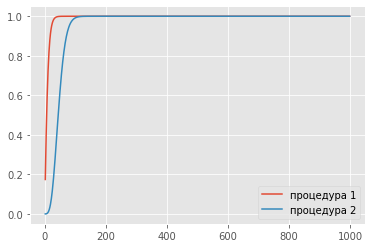

In [6]:
def power_1(n_obs, alpha=0.05, mu1=4, mu2=5, sigma=1):
    z_crit = stats.norm().ppf(1 - alpha)
    a = z_crit - (mu2 - mu1)/np.sqrt(2 * sigma/n_obs)
    return 1 - stats.norm().cdf(a)

def power_2(n_obs, alpha=0.05, mu1=4, mu2=5, sigma=1):
    z_crit = stats.norm().ppf(1 - alpha)
    a = 2*np.sqrt(2)*z_crit - (mu2 - mu1)/np.sqrt(2 * sigma/n_obs)
    return 1 - stats.norm().cdf(a)

obs = np.arange(1, 1000)

plt.plot(obs, power_1(obs), label='процедура 1')
plt.plot(obs, power_2(obs), label='процедура 2')
plt.legend( );

Теперь проведем много тестов (с поправкой Сидака) и посмотрим,
в скольких случаях мы сможем обнаружить эффект при помощи двух процедур.
Поправка Сидака: сравниваем p-value или строим доверительные интервалы для уровня значимости:
$
\alpha_{correction} = 1 - (1 - \alpha)^{1/m}
$


In [7]:
def get_size(mean1, mean2, alpha, beta, sd):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta =  stats.norm.ppf(1 - beta)
    n = (np.sqrt(2) * sd * (z_beta + z_alpha) / (mean1 - mean2))**2
    return np.int16(n)

def conf_int_calc_type1(data, alpha, sd):
    """
    Calculate confident intervals for two datasets for significance level in the first case
    :param data: dataset (nrow - observation, ncol - number of variants)
    :param sd: standard deviation of population
    :param alpha: significance level
    :return: confident interval (tuple)
    """
    z_crit = stats.norm().ppf(1 - alpha)
    n = data.shape[0]
    mean1, mean2 = data['1'].mean(), data['2'].mean()
    sd1, sd2 = sd, sd

    ci1 =  (mean1 - z_crit * sd1 / np.sqrt(n),
            mean1 + z_crit * sd1 / np.sqrt(n))
    ci2 =  (mean2 - z_crit * sd2 / np.sqrt(n),
            mean2 + z_crit * sd2 / np.sqrt(n))

    if ci1[0] > ci2[1]:
        return "средние не равны"
    else:
        return "средние равны"

def conf_int_calc_type2(data, alpha, sd):
    z_crit = stats.norm().ppf(1 - alpha/2)
    n = data.shape[0]
    mean1, mean2 = data['1'].mean(), data['2'].mean()

    ci = (mean1 - mean2 - np.sqrt((2 * sd**2)/n) * z_crit,
          mean1 - mean2 + np.sqrt((2 * sd**2)/n) * z_crit)
    if (ci[0] < 0) & (ci[1] > 0):
        return "средние равны"
    else:
        return "средние не равны"

from collections import Counter
results_dividing = []
results_paired = []
results_p_values_test = []
p_values_list = []
alpha = 0.05
mean1, mean2, sd = 1.5, 1, 5
print(f"Нужно юзеров, чтобы уловить эффект изменения: {get_size(mean1, mean2, 0.05, 0.2, sd=sd)}")
for i in range(1, 1001):
    np.random.seed(i)
    data = pd.DataFrame(columns=list("12"))
    alpha_correction = 1 - (1 - alpha) ** (1/i)
    size = get_size(mean1, mean2, alpha_correction, beta=0.2, sd=sd)
    data['1'] = np.random.normal(loc=mean1, scale=sd, size=size)
    data['2'] = np.random.normal(loc=mean2, scale=sd, size=size)

    results_dividing.append(conf_int_calc_type1(data, alpha_correction, sd=sd))
    results_paired.append(conf_int_calc_type2(data, alpha_correction, sd=sd))
    stat, p = stats.ttest_ind(data['1'], data['2'], equal_var=True)
    p_values_list.append(p)
    if p < alpha_correction:
        results_p_values_test.append("средние не равны")
    else:
        results_p_values_test.append("средние равны")
print(f"Доверительные интервалы для каждого среднего: {Counter(results_dividing)}")
print(f"Доверительные интервалы для разницы: {Counter(results_paired)}")
print(f"Готовый стат тест: {Counter(results_p_values_test)}")


Нужно юзеров, чтобы уловить эффект изменения: 1569
Доверительные интервалы для каждого среднего: Counter({'средние равны': 665, 'средние не равны': 335})
Доверительные интервалы для разницы: Counter({'средние не равны': 836, 'средние равны': 164})
Готовый стат тест: Counter({'средние не равны': 833, 'средние равны': 167})


In [8]:
cm = sms.CompareMeans(sms.DescrStatsW(data['1']), sms.DescrStatsW(data['2']))
print(f"Доверительный интервал для разницы: {cm.tconfint_diff(usevar='pooled')}")

def conf_int_calc_type2(data, alpha, sd):
    z_crit = stats.norm().ppf(1 - alpha/2)
    n = data.shape[0]
    mean1, mean2 = data['1'].mean(), data['2'].mean()

    ci = (mean1 - mean2 - np.sqrt((2 * sd ** 2)/n) * z_crit,
          mean1 - mean2 + np.sqrt((2 * sd ** 2)/n) * z_crit)
    print(ci)
    if (ci[0] < 0) & (ci[1] > 0):
        return "средние равны"
    else:
        return "средние не равны"
conf_int_calc_type2(data, 0.05, sd=5)

Доверительный интервал для разницы: (0.2551996317759111, 0.6589323497410244)
(0.25669377178583397, 0.657438209731102)


'средние не равны'

# Проверка множественных гипотез - случай выбора лучшего варианта более чем из двух

Про рост ошибки 1 рода во множественном тестировании написано в лекции по АБ-тестам. Здесь попробуем реализовать
две процедуры, которые активно используются для решения этой проблемы.

## Процедура FDR Бенджамини-Хохберга

Пусть у нас есть $n$ альтернативных вариантов дизайна приложения.
Число сравнений $k = C_n^k$ - число сочетаний из $n$ по $k$, где
$C_n^k = \frac {n!} {n! (n-k)!}$. Например, для 3 вариантов нужно
провести 3 сравнительных теста (3! / (1! * 2!)), для 4 вариантов 6
сравнительных тестов (4! / (2! * 2!) и т. д.

Тогда:

1. Проводим тест Стьюдента / Манна-Уитни / Бутстрап для каждой пары вариантов
2. Вычисляем тестовые статистики (в случае бутстрапа получаем просто распределение разницы средних)
3. Вычисляем $p-value$
4. Сортируем по возрастанию $p-value$ наши сравнительные тесты:

$p_1 \leq p_2 \leq ... p_k $
5. Фиксируем уровень значимости $\alpha$. Это будет уровень значимости для последнего теста с $p_{value} = p_k$
6. Далее корректируем уровни значимости по следующему правилу:
$\alpha_1 = \frac {\alpha} {k}, \alpha_2 = \frac {2\alpha} {k},
\alpha_i = \frac {\alpha i} {k} ... \alpha_k = \alpha \
$
7. Принимаем решение, исходя из следующего:
 - Если $p_k < \alpha_k$ - отвергаем ВСЕ гипотезы (разница в средних везде есть)
 - Если $p_{k-1} < \alpha_{k-1} $ - отвергаем оставшиеся гипотезы, а эту не отвергнуть
(разница есть везде, кроме этих двух вариантов)
 - ...
 - Продолжаем, пока не закончатся гипотезы

Ниже реализуем данный алгоритм на примере. Возьмем 4 альтернативных варианта.
Будем использовать тест Стьюдента с разными дисперсиями (Welsh's test).

In [20]:
from itertools import combinations



,statistic,p_value
"(0, 1)",NaN,NaN
"(0, 2)",NaN,NaN
"(0, 3)",NaN,NaN
"(1, 2)",NaN,NaN
"(1, 3)",NaN,NaN
"(2, 3)",NaN,NaN


Выборочные средние: [0.28749378 0.28988384 0.31006486 0.35372863]


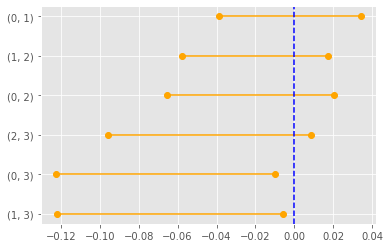

In [167]:
def create_confidence_plot(df_results):

    for lower,upper,y in zip(df_results['lower'],df_results['upper'],range(len(df_results))):
        plt.plot((lower,upper),(y,y),'ro-',color='orange');
    plt.yticks(range(len(df_results)),list(df_results.index));
    plt.axvline(x=0, color='b', ls='--');


def student_multiple_test(data, alpha=0.05, beta=0.8, equal_var=False):
    """
    Student test for independent two samples
    :param equal_var: assumption about variance
    :param data: np.array where shape[1] == number of potential variants
    :param alpha: significance level
    :param beta: type II error (1 - power of test)
    :return: tuple(test statistic, p value of test)
    """

    k = comb(data.shape[1], 2)  # number of multiple comparisons
    all_comparisons_list = list(combinations(np.arange(data.shape[1]), 2))
    all_comparisons_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(list(combinations(np.arange(data.shape[1]), 2)),
                                                                  names=['var1', 'var2']),
                                  columns=['statistic', 'p_value'])
    for index, row in all_comparisons_df.iterrows():
        all_comparisons_df.loc[index, "diff_mean"] = data[:, index[0]].mean() - data[:, index[1]].mean()
        stat_test, p_value = ttest_ind(data[:, index[0]], data[:, index[1]], equal_var=equal_var)
        all_comparisons_df.loc[index, "statistic"] = stat_test
        all_comparisons_df.loc[index, "p_value"] = p_value

    all_comparisons_df.sort_values(['p_value'], inplace=True)
    all_comparisons_df['i'] = np.arange(all_comparisons_df.shape[0]) + 1
    all_comparisons_df['alpha_correction'] = (all_comparisons_df['i'] * alpha ) / k
    all_comparisons_df['stat_significance'] = np.where(all_comparisons_df['p_value'] >
                                                       all_comparisons_df['alpha_correction'], False, True)
    # Create confident intervals for difference with correction significance level
    for index, row in all_comparisons_df.iterrows():
        cm = sms.CompareMeans(sms.DescrStatsW(data[:, index[0]]), sms.DescrStatsW(data[:, index[1]]))
        all_comparisons_df.loc[index, "lower"] = cm.tconfint_diff(usevar='unequal',
                                                                                alpha=row['alpha_correction'])[0]
        all_comparisons_df.loc[index, "upper"] = cm.tconfint_diff(usevar='unequal',
                                                                                alpha=row['alpha_correction'])[1]

    # Determine winners
    for index, row in all_comparisons_df.iterrows():
        all_comparisons_df.loc[index, "winner"] = np.where((row['stat_significance'] == True) &
                                                           (row['statistic'] < 0),
                                                           str(index[1]), np.where(row['stat_significance'] == True,
                                                                              str(index[0]), "not_winner")).item()
    winner_count = all_comparisons_df['winner'].value_counts()

    winner = None
    if np.all(np.array(winner_count.index)) == "not_winner":
        winner = "not_winner"



    return all_comparisons_df, winner_count
data_testing = np.random.lognormal(mean=[-1.75, -1.75, -1.71, -1.7], sigma=[1, 1.01, 1.05, 1.1],
                                   size=(1000, 4))
print(f"Выборочные средние: {data_testing.mean(axis=0)}")
df, counts = student_multiple_test(data_testing)
create_confidence_plot(df[['lower', 'upper']])

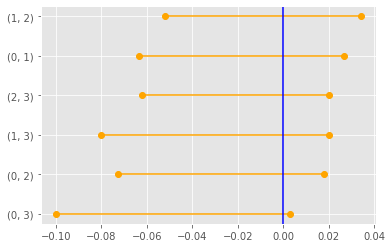

Проблема может быть в том, что не всегда мы можем выявить четкого победителя.
Зачастую у нас будет на выбор несколько вариантов-победителей (один не лучше другого, но они лучше остальных).




In [59]:
all_comparisons_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(list(combinations(np.arange(4), 2)),
                                                                  names=['var1', 'var2']),
                                  columns=['statistic', 'p_value'])
all_comparisons_df.index

MultiIndex([(0, 1),
            (0, 2),
            (0, 3),
            (1, 2),
            (1, 3),
            (2, 3)],
           names=['var1', 'var2'])